# In memory dataset

This notebooks explains an alternative way of measuring where the raw data is not written directly to a sqlite database file but only kept in memory with the ability to export the data after the measurement is completed. This may significantly speed up measurements where a lot of data is acquired but there is no protection against any data lose that may happen during a measurement. (Power loss, computer crash etc.) However, there may be situations where this trade-off is worthwhile. Please do only use the in memory dataset for measurements if you understand the risks. 

In [1]:
%matplotlib inline
import numpy.random as rd
import matplotlib.pyplot as plt
import numpy as np

import qcodes as qc
from qcodes.dataset import (
    load_or_create_experiment,
    load_by_guid,
    load_by_run_spec,
    initialise_or_create_database_at,
    Measurement,
    DataSetTypes,
    plot_dataset,
)
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

Here we set up two mock instruments and a database to measure into:

In [2]:
# preparatory mocking of physical setup

dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement(name="dmm", setter_instr=dac)

station = qc.Station(dmm, dac)

In [3]:
initialise_or_create_database_at("./in_mem_example.db")
exp = load_or_create_experiment(experiment_name="in_mem_exp", sample_name="no sample")

And run a standard experiment writing data to the database: 

In [4]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.write_period = 0.5

with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v), (dmm.v1, get_v))

    dataset1D = datasaver.dataset  # convenient to have for data access and plotting

Starting experimental run with id: 16. 


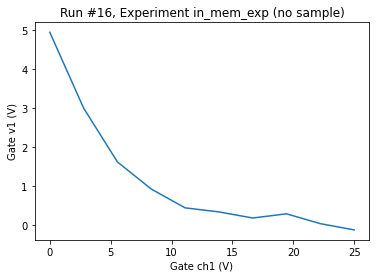

In [5]:
ax, cbax = plot_dataset(dataset1D)

The in memory measurement looks nearly identical with the only difference being that we explicitly pass in an Enum to select the dataset class that we want to use as a parameter to ``measurement.run``

The ``DataSetTypes`` Enum currently has 2 members representing the two different types of dataset supported.

In [6]:
with meas.run(dataset_class=DataSetTypes.DataSetInMem) as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v), (dmm.v1, get_v))
    datasetinmem = datasaver.dataset

Starting experimental run with id: 17. 


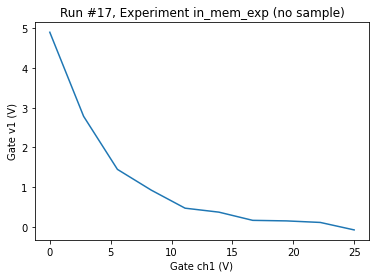

In [7]:
ax, cbax = plot_dataset(datasetinmem)

In [8]:
datasetinmem.run_id

17

When the measurement is performed in this way the data is not written to the database but the metadata (run_id, timestamps, snapshot etc.) is.

To preserve the raw data it must be exported it to another file format. See [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) for more information on exporting including how this can be done automatically.

In [9]:
datasetinmem.export("netcdf", path=".")

The `export_info` attribute contains information about locations where the file was exported to. We will use this below to show how the data may be reloaded from a netcdf file.

In [10]:
path_to_netcdf = datasetinmem.export_info.export_paths["nc"]
path_to_netcdf

'C:\\Users\\jenielse\\source\\repos\\Qcodes\\docs\\examples\\DataSet\\qcodes_17.nc'

As expected we can see this file in the current directory.

In [11]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is A6E9-9402

 Directory of C:\Users\jenielse\source\repos\Qcodes\docs\examples\DataSet

29/10/2021  10:31    <DIR>          .
27/09/2021  09:36    <DIR>          ..
27/10/2021  12:01    <DIR>          .ipynb_checkpoints
26/10/2021  10:35           885,940 Accessing-data-in-DataSet.ipynb
27/09/2021  09:36            17,673 Benchmarking.ipynb
27/09/2021  09:36    <DIR>          Cache
26/10/2021  10:35            79,094 DataSet-class-walkthrough.ipynb
27/09/2021  09:36            85,237 Dataset_Performance.ipynb
29/10/2021  10:30           353,894 Exporting-data-to-other-file-formats.ipynb
29/10/2021  10:28         2,838,528 export_example.db
29/10/2021  10:28            32,768 export_example.db-shm
29/10/2021  10:28         3,040,592 export_example.db-wal
27/09/2021  09:36            16,283 Extracting-runs-from-one-DB-file-to-another.ipynb
14/10/2021  16:10            78,918 import-data-from-legacy-dat-files.ipynb
29/10/2021  10:29 

Note that you can interact with the dataset via the `cache` attribute of the dataset in the same way as you can with a regular dataset. However the in memory dataset does not implement methods that provide direct access to the data from the dataset object it self (get_parameter_data etc.) since these read data from the database. 

## Reloading data from db and exported file

In [12]:
from qcodes import load_by_run_spec
from qcodes.dataset.plotting import plot_dataset

In [13]:
ds = load_by_run_spec(captured_run_id=datasetinmem.captured_run_id)

([<AxesSubplot:title={'center':'Run #17, Experiment in_mem_exp (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

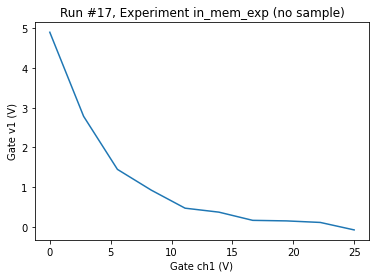

In [14]:
plot_dataset(ds)

A dataset can also be loaded directly from the netcdf file. See [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) for more information on how this is done. 